In [1]:
import os, gc

import pandas as pd
import numpy as np
import polars as pl
from sklearn.model_selection import GroupKFold

import matplotlib.pyplot as plt

import lightgbm as lgb
from psutil import cpu_count

In [2]:
class config:
    data_path = "../data/"
    validation_path = "../data/local_validation/"
    model_path = "../models/"

In [3]:
candidate_df = pd.read_parquet(
    "../artifacts/candidate_df_clicks_with_features_with_targets.parquet"
)
display(candidate_df.head())

,session,aid,item_n_clicks_24h,item_n_carts_24h,item_n_orders_24h,item_n_clicks_7d,item_n_carts_7d,item_n_orders_7d,item_avg_click_hour,item_avg_cart_hour,...,user_n_clicks_7d,user_n_carts_7d,user_n_orders_7d,user_n_unique_items_7d,user_n_unique_items_24h,user_session_length,user_avg_click_hour,user_avg_cart_hour,user_avg_order_hour,clicks
0,11098528,77440,156,7,0,1006,129,12,13.438680,12.600585,...,1,0,0,1,1,1,22.0,-1.0,-1.0,0
1,11098528,42241,14,6,0,62,20,2,13.883383,13.910150,...,1,0,0,1,1,1,22.0,-1.0,-1.0,0
2,11098528,628354,3,0,0,31,2,0,13.771106,13.327684,...,1,0,0,1,1,1,22.0,-1.0,-1.0,0
3,11098528,1666688,4,0,1,60,4,2,13.534181,12.967213,...,1,0,0,1,1,1,22.0,-1.0,-1.0,0
4,11098528,1732105,34,1,0,255,73,7,13.468257,12.648375,...,1,0,0,1,1,1,22.0,-1.0,-1.0,0


In [4]:
positives = candidate_df.loc[candidate_df["clicks"] == 1]
negatives = candidate_df.loc[candidate_df["clicks"] == 0].sample(
    7 * len(positives), random_state=42
)
candidate_df = pd.concat([positives, negatives], axis=0, ignore_index=True)

In [5]:
del positives, negatives

In [6]:
features = candidate_df.columns.drop(["session", "aid", "clicks"]).tolist()

In [7]:
candidate_df = candidate_df.sort_values("session").reset_index(drop=True)

In [10]:
params = {
    # Core Parameters
    "objective": "lambdarank",
    "boosting": "gbdt",  # default: 'gbdt', ['gbdt', 'dart', 'goss'], dart: 超遅いけど高精度
    "num_iterations": 2000,
    "learning_rate": 0.02,
    "num_leaves": 31,  # default: 31, large for accuracy
    "num_threads": cpu_count(logical=False),
    "random_state": 41,
    # Learning Control Parameters
    "force_col_wise": True,
    # 'histogram_pool_size': -1.0,  # default: -1.0, max cache size in MB for historical histogram, (histogram_pool_size + dataset size) = approximately RAM used
    "min_data_in_leaf": 20,  # default: 20, large dealing with over-fitting
    "min_sum_hessian_in_leaf": 1e-3,  # default: 1e-3, large dealing with over-fitting
    "max_depth": -1,
    "bagging_freq": 5,
    "bagging_fraction": 0.8,
    "feature_fraction": 0.8,
    # 'drop_rate': 0.1,  # used only in dart, a fraction of previous trees to drop during the dropout
    "verbosity": 0,  # 0: warnings, 1: info
    # Dataset Parameters
    "max_bin": 255,  # default: 255, large for accuracy
    "min_data_in_bin": 3,  # default: 3,
    "bin_construct_sample_cnt": 200000,  # default: 200000, larger for accuracy
    # Objective Parameters
    "lambdarank_truncation_level": 30,
    "lambdarank_norm": True,
    # 'label_gain': [0, 1],
    # Metric Parameters
    "metric": ["ndcg"],
    "eval_at": [20],  # 上位何件のランキングをnDCGとMAPの算出に用いるか
}

In [11]:
skf = GroupKFold(n_splits=2)
for fold, (train_idx, valid_idx) in enumerate(
    skf.split(candidate_df, candidate_df["clicks"], groups=candidate_df["session"])
):
    train_df = candidate_df.loc[train_idx]
    train_df = train_df.sort_values("session", ascending=True)
    train_query = train_df.groupby("session")["session"].count().to_list()

    valid_df = candidate_df.loc[valid_idx]
    valid_df = valid_df.sort_values("session", ascending=True)
    valid_query = valid_df.groupby("session")["session"].count().to_list()

    X_train = train_df[features]
    y_train = train_df["clicks"]
    X_valid = valid_df[features]
    y_valid = valid_df["clicks"]

    dtrain = lgb.Dataset(X_train, label=y_train, group=train_query)
    dvalid = lgb.Dataset(X_valid, y_valid, group=valid_query)

    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dtrain, dvalid],
        callbacks=[
            lgb.early_stopping(50, first_metric_only=True),
            lgb.log_evaluation(50),
        ],
    )

    model.save_model(f"{config.model_path}XGB_fold{fold}_click.xgb")
    del dtrain, dvalid, X_train, X_valid, y_train, y_valid, train_df, valid_df
    gc.collect()

/home/cargobuild/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
[50]	training's ndcg@20: 0.822889	valid_1's ndcg@20: 0.822296
[100]	training's ndcg@20: 0.823635	valid_1's ndcg@20: 0.822929
[150]	training's ndcg@20: 0.824335	valid_1's ndcg@20: 0.823561
[200]	training's ndcg@20: 0.82506	valid_1's ndcg@20: 0.824191
[250]	training's ndcg@20: 0.825895	valid_1's ndcg@20: 0.824703
[300]	training's ndcg@20: 0.826643	valid_1's ndcg@20: 0.825254
[350]	training's ndcg@20: 0.827398	valid_1's ndcg@20: 0.825853
[400]	training's ndcg@20: 0.828106	valid_1's ndcg@20: 0.826321
[450]	training's ndcg@20: 0.828773	valid_1's ndcg@20: 0.826816
[500]	training's ndcg@20: 0.829357	valid_1's ndcg@20: 0.827142
[550]	training's ndcg@20: 0.829905	valid_1's ndcg@20: 0.827508
[600]	training's ndcg@20: 0.830438	valid_1's ndcg@20: 0.827815
[650]	training's ndcg@20: 0.830831	valid_1's ndcg@20: 0.827971
[700]	training's ndcg@20: 0.831334	valid_1's ndcg@20: 0.828237
[750]	training's ndcg@20: 0.831806	valid_1's ndcg@20: 0.828

/home/cargobuild/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
[50]	training's ndcg@20: 0.822809	valid_1's ndcg@20: 0.822465
[100]	training's ndcg@20: 0.823698	valid_1's ndcg@20: 0.823177
[150]	training's ndcg@20: 0.824502	valid_1's ndcg@20: 0.823822
[200]	training's ndcg@20: 0.825406	valid_1's ndcg@20: 0.824572
[250]	training's ndcg@20: 0.826029	valid_1's ndcg@20: 0.82495
[300]	training's ndcg@20: 0.826854	valid_1's ndcg@20: 0.825662
[350]	training's ndcg@20: 0.827546	valid_1's ndcg@20: 0.826152
[400]	training's ndcg@20: 0.828234	valid_1's ndcg@20: 0.826686
[450]	training's ndcg@20: 0.828933	valid_1's ndcg@20: 0.827125
[500]	training's ndcg@20: 0.829499	valid_1's ndcg@20: 0.827496
[550]	training's ndcg@20: 0.830053	valid_1's ndcg@20: 0.827893
[600]	training's ndcg@20: 0.830606	valid_1's ndcg@20: 0.828181
[650]	training's ndcg@20: 0.831095	valid_1's ndcg@20: 0.828457
[700]	training's ndcg@20: 0.831554	valid_1's ndcg@20: 0.828686
[750]	training's ndcg@20: 0.831909	valid_1's ndcg@20: 0.828

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

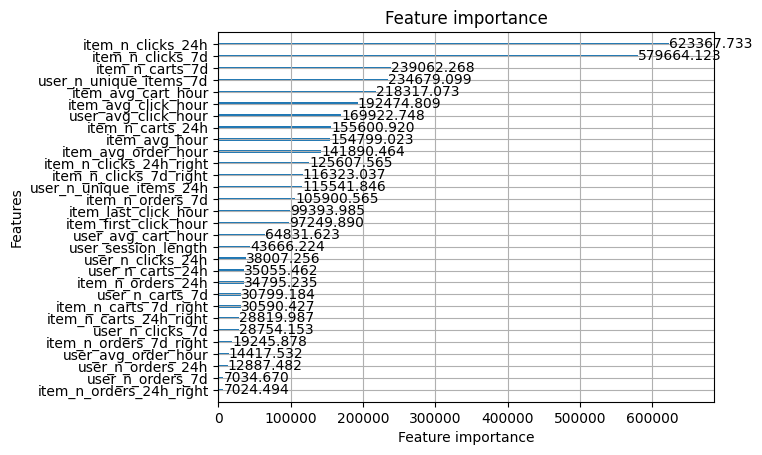

In [12]:
lgb.plot_importance(model, importance_type="gain", max_num_features=30)

In [3]:
test_candidates = pd.read_parquet(
    "../artifacts/candidate_df_clicks_with_features.parquet"
)

In [4]:
features = test_candidates.columns.drop(["session", "aid"]).tolist()

In [5]:
import pickle


def predict(test_df: pd.DataFrame, model_folds: list, features: list):
    preds = np.zeros(len(test_df))
    for w in model_folds:
        model = lgb.Booster(model_file=f"../models/XGB_fold{w}_click.xgb")
        preds += model.predict(test_df[features], num_iteration=model.best_iteration)
    preds /= len(model_folds)
    predictions = test_df[["session", "aid"]].copy()
    predictions["pred"] = preds
    return predictions

In [6]:
preds = predict(test_candidates, [0, 1], features)

In [7]:
preds

,session,aid,pred
0,11098528,77440,0.714513
1,11098528,42241,-0.347916
2,11098528,628354,-0.388250
3,11098528,1666688,-0.383582
4,11098528,1732105,0.190277
...,...,...,...
116146577,12899778,771572,-0.263206
116146578,12899778,13942,-0.404017
116146579,12899778,1819895,-0.434413
116146580,12899778,1167224,-0.603495


In [8]:
predictions = preds.sort_values(
    ["session", "pred"], ascending=[True, False]
).reset_index(drop=True)
predictions["n"] = predictions.groupby("session").aid.cumcount().astype("int8")
predictions = predictions.loc[predictions.n < 20]
sub = predictions.groupby("session").aid.apply(list)
sub = sub.to_frame().reset_index()

In [9]:
# add suffix to session column
sub["session"] = sub["session"].astype(str) + "_clicks"
sub.columns = ["session_type", "labels"]
sub["labels"] = sub.labels.apply(lambda x: " ".join(map(str, x)))

In [10]:
sub

,session_type,labels
0,11098528_clicks,11830 756588 876129 884502 231487 77440 158617...
1,11098529_clicks,1715900 1452043 295362 1745584 612829 431777 8...
2,11098530_clicks,1604220 1596897 1603001 1066554 963957 409236 ...
3,11098531_clicks,1557766 396199 1728212 1271998 839277 897416 1...
4,11098532_clicks,108125 659399 1202618 650580 1754057 1645990 1...
...,...,...
1801246,12899774_clicks,1497313 771913 95488 819288 1157411 1539309 27...
1801247,12899775_clicks,310546 329725 29735 832192 614363 1760714 6700...
1801248,12899776_clicks,942224 1411324 1153248 1144446 1145564 334325 ...
1801249,12899777_clicks,364190 1196256 247240 613752 703474 1104713 35...


In [11]:
score = 0
weights = {"clicks": 0.10, "carts": 0.30, "orders": 0.60}
for t in ["clicks"]:
    sub: pd.DataFrame = sub.loc[sub.session_type.str.contains(t)].copy()
    sub["session"] = sub.session_type.apply(lambda x: int(x.split("_")[0]))
    sub.labels = sub.labels.apply(lambda x: [int(i) for i in x.split(" ")[:20]])
    test_labels: pd.DataFrame = pd.read_parquet(
        "../data/local_validation/test_labels.parquet"
    )
    test_labels = test_labels.loc[test_labels["type"] == t]
    test_labels = test_labels.merge(sub, how="left", on=["session"])
    test_labels["hits"] = test_labels.apply(
        lambda df: len(set(df.ground_truth).intersection(set(df.labels))),
        axis=1,
    )
    test_labels["gt_count"] = test_labels.ground_truth.str.len().clip(0, 20)
    recall = test_labels["hits"].sum() / test_labels["gt_count"].sum()
    score += weights[t] * recall
    print()
    print(f"{t} recall =", recall)

print("=============")
print("Overall Recall =", score)
print("=============")


clicks recall = 0.32733287991004445
Overall Recall = 0.032733287991004445
